In [1]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

from base import supres, BaseStrategy
from exputils import *

# Load Data

In [2]:
# dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'
features = ['support']

In [4]:
pairs = pd.read_csv('selected-pairs.tsv', header=None)[0].tolist()
train_dict = {pair: read_train(pair, dropbox_dir) for pair in pairs}
test_dict = {pair: read_test(pair, dropbox_dir) for pair in pairs}
data_dict = {pair: read_all(pair, dropbox_dir) for pair in pairs}

In [5]:
ohlc_supports_test_dict = load_model('ohlc_supports_test.pkl')
ohlc_supports_train_dict = load_model('ohlc_supports_train.pkl')

def _append(pair, w_size):
    return ohlc_supports_train_dict[pair][w_size] + ohlc_supports_test_dict[pair][w_size]

def _w_sizes(pair):
    return ohlc_supports_train_dict[pair].keys()

ohlc_supports_dict = {pair: {w_size: _append(pair, w_size) for w_size in _w_sizes(pair)} for pair in pairs}

In [7]:
rpath = os.path.join(dropbox_dir,'result', 'base-strategy2-learn-02.pkl')
results = pd.read_pickle(rpath)

days = 365 * 2
results['tradesPerDay'] = results['numberOfTrades'] / days
results['profitPerDay'] = results['totalProfit'] / days

In [8]:
print(results.shape)
results.head()

(100320, 19)


,pair,window_size,profit_targets,stop_loss,_return,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,avgTimeToClose,minTimeToClose,maxTimeToClose,tradesPerDay,profitPerDay
0,BTC_ETH,4,"[0.01, 0.03]",0.0200,0.0100,100.0000,"2,955.0000",-98.5495,-0.0334,55.3976,0.5732,-0.7867,0.9049,99.5550,6.0189,0.1000,179.1000,4.0479,-0.1350
1,BTC_ETH,4,"[0.01, 0.03]",0.0100,0.0200,100.0000,"4,591.0000",-99.9895,-0.0218,33.9577,0.2332,-0.1529,0.7843,99.9899,3.0291,0.1000,70.1000,6.2890,-0.1370
2,BTC_ETH,4,"[0.01, 0.03]",0.0100,0.0100,100.0000,"3,990.0000",-99.9720,-0.0251,33.8095,0.2498,-0.1654,0.7712,99.9730,3.1516,0.1000,70.1000,5.4658,-0.1369
3,BTC_ETH,4,"[0.01, 0.03]",0.0200,0.0300,100.0000,"3,594.0000",-99.1892,-0.0276,55.4814,0.5758,-0.7796,0.9205,99.7250,5.6282,0.1000,179.1000,4.9233,-0.1359
4,BTC_ETH,4,"[0.01, 0.03]",0.0100,0.0400,100.0000,"5,123.0000",-99.9941,-0.0195,34.3354,0.2580,-0.1646,0.8194,99.9944,2.9001,0.1000,70.1000,7.0178,-0.1370


# Select Params

Intersting formula

E= [1+ (W/L)] x P – 1

Where:

- W means the size of your average win
- L means the size of your average loss
- P means winning rate

In [56]:
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [90]:
results['zTotalProfit'] = min_max(results['totalProfit'])
results['zWinPercentage'] = min_max(results['winPercentage'])
results['zAvgLossTrade'] = min_max(results['avgLossTrade'])
results['meanStats'] = (results['zTotalProfit'] + 
                        (3 * results['zWinPercentage']) + 
                        results['zAvgLossTrade'] * (1 - results['winPercentage'] / 100)) / 3

In [136]:
selected_params = pd.DataFrame()
for pair in pairs:
    p_results = results[results['pair'] == pair]
    p_results = reset_index_hard(p_results).copy()
    p_results['target_0'] = p_results['profit_targets'].apply(lambda x: x[0])
    row = p_results.query('totalProfit > 0')\
        .sort_values('meanStats', ascending=False).iloc[0, :]
    selected_params = selected_params.append(row)

In [137]:
cols = ['pair', 'window_size', 'profit_targets', 'stop_loss', '_return', 
 'tradesPerDay', 'totalProfit', 'maxTimeToClose', 'winPercentage']
selected_params[cols]

,pair,window_size,profit_targets,stop_loss,_return,tradesPerDay,totalProfit,maxTimeToClose,winPercentage
3791,BTC_ETH,12.0000,"[0.01, 0.08]",0.1000,0.0500,0.9644,346.8632,924.9000,91.6193
1880,BTC_XRP,6.0000,"[0.01, 0.05]",0.1000,0.0500,1.5603,186.9685,849.9000,88.8499
3834,BTC_LTC,12.0000,"[0.01, 0.09]",0.0900,0.0500,0.5973,91.3662,"2,250.1000",87.1560
2080,BTC_XMR,6.0000,"[0.01, 0.09]",0.1000,0.0500,1.8671,463.5688,567.9000,90.0220
1829,BTC_STR,6.0000,"[0.01, 0.04]",0.0800,0.0500,2.4521,733.6410,455.1000,90.0000
3790,BTC_DASH,12.0000,"[0.01, 0.08]",0.1000,0.0500,0.9603,315.1382,748.2000,91.4408
3641,BTC_BTS,12.0000,"[0.01, 0.05]",0.1000,0.0500,1.1699,494.9177,699.1000,92.7400
1931,BTC_FCT,6.0000,"[0.01, 0.06]",0.1000,0.0500,2.2370,826.4848,330.9000,90.6307
120,BTC_XEM,4.0000,"[0.01, 0.05]",0.1000,0.0500,2.6397,758.9814,443.1000,89.5693
3588,BTC_MAID,12.0000,"[0.01, 0.04]",0.0800,0.0400,1.2411,598.7064,383.1000,92.3841


# Wallet history

In [93]:
def combine_dicts(d1, d2):
    keys = list(d1.keys()) + list(d2.keys())
    d = {}
    for k in keys:
        v1, v2 = d1.get(k, None), d2.get(k, None)
        if v1 is None:
            d[k] = v2
        elif v2 is None:
            d[k] = v1
        elif type(v1) == dict:
            d[k] = combine_dicts(v1, v2)
        else:
            d[k] = v1 + v2
    return d

In [94]:
import pandas as pd
import numpy as np
from trading.money.transaction import Transaction
    

class WalletHistory:
    def __init__(self, start_wallet):
        self.start_wallet = deepcopy(start_wallet)
        self.wallet = start_wallet
        self.wallet_history = {}

    def history(self, transactions):
        for transaction in transactions:
            if transaction['type'] == 'BUY':
                self._buy(transaction)
            else:
                self._sell(transaction)
        return self.wallet_history
                
    def _buy(self, transaction):
        subtracted = Contract.add(Transaction.subtracted_contract(transaction), transaction['fee'])
        gained = Transaction.gained_contract(transaction)
        self._add(gained)
        self._subtract(subtracted)
        self._add_to_history(self.wallet, transaction['timestamp'])
        

    def _sell(self, transaction):
        subtracted = Transaction.subtracted_contract(transaction)
        gained = Contract.sub(Transaction.gained_contract(transaction), transaction['fee'])
        self._add(gained)
        self._subtract(subtracted)
        self._add_to_history(self.wallet, transaction['timestamp'])
    
    def _add_to_history(self, wallet, ts):
        wallet_p = self.wallet_history.get(ts, {})
        self.wallet_history[ts] = combine_dicts(deepcopy(wallet), deepcopy(wallet_p))
    
    def _add(self, contract):
        name, value = contract
        self.wallet[name] = self.wallet.get(name, 0.) + value

    def _subtract(self, contract):
        self._add(Contract.mul(contract, -1))

In [95]:
price_dict = {pair: test_dict[pair]['close'].tolist() for pair in pairs}

In [96]:
from itertools import product

def profolio_value_f(args):
    ts, wallet = args
    ts = int(ts)
    btc = wallet.get('btc', 0)
    for currency, amount in wallet.items():
        if currency == 'btc' or amount == 0:
            continue
        data = price_dict[f'BTC_{currency.upper()}']
        price = data[ts]
        btc += amount * price

    return ts, btc


def portfolio_value(strategy, data_dict, pair=None):
    def _get(ts, col='close'):
        t = ts if ts < data.shape[0] else data.shape[0]-1
        row = data.iloc[t, :]
        return row[col]
    
    data = data_dict[pair]
    transactions = strategy.exchange.transactions
    history = WalletHistory({'btc': 100}).history(transactions)
    args = history.items()
    results = run_parallel(profolio_value_f, args)
    df = pd.DataFrame(results, columns=['timestamp', 'btc'])
    df['btc_return_%'] = ((df['btc'] / 100) - 1) * 100
    if pair is not None:
        df['hold'] = df['timestamp'].apply(_get)
        first_price = _get(0)
        df['hold_return_%'] = ((df['hold'] / first_price) - 1) * 100
    df['index'] = df['timestamp']
    df['timestamp'] = df['index'].apply(lambda ts: _get(ts, 'timestamp'))
    return df

In [97]:
import matplotlib.dates as md
def plot_portfolio_value(df, step=10, title='Portfolio return over time'):
    
    f = plt.figure(figsize=[12, 6])

    df['date'] = df['timestamp'].apply(dt.datetime.fromtimestamp)
    selected = df.iloc[[i for j, i in enumerate(df.index) if j % step == 0], :]\
        .sort_values('timestamp')\
        .reset_index()
    xdates = selected['date']
    ax = sns.lineplot(xdates, selected['btc_return_%'], label='strategy', marker='o')
    if 'hold' in df.columns:
        ax = sns.lineplot(xdates, selected['hold_return_%'], label='hold', marker='o')
    
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(MaxNLocator(6))

    plt.title(title, fontproperties=title_font)
    plt.xlabel('date', fontproperties=axis_font)
    plt.ylabel('return (%)', fontproperties=axis_font)
    plt.show()

# Test Selected

In [133]:
def get_strategy(data, pair, profit_targets, willing_loss, _return):
    contract_pair = ContractPair.new(*[x.lower() for x in pair.split('_')])
    dm = OhlcDataManager(data[['open', 'low', 'high', 'close']], data[features])
    wallet = {'btc': 100}
    exchange = BackTestExchange(dm, wallet, 0.0025)
    strategy = BaseStrategy(exchange, 
                            dm, 
                            contract_pair, 
                            willing_loss=willing_loss,  
                            target_return=_return,
                            profit_targets=profit_targets)
    strategy.trade()
    return strategy

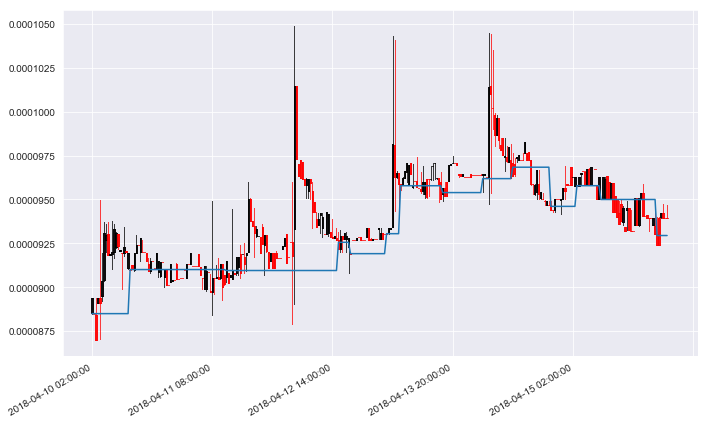

In [134]:
data = test_dict[pair]
data['support'] = ohlc_supports_test_dict[pair][window_size]
data = data.query('date >= "2018-04-10" and date <= "2018-04-16"').reset_index()
plot_candles(data)
plt.plot(data['support'])

                      btc
startAmount      100.0000
numberOfTrades   200.0000
totalProfit      -53.0548
avgProfit         -0.2653
winPercentage     84.5000
avgWinTrade        0.9818
avgLossTrade      -7.0640
profitFactor       0.7577
maxDrawdown       73.1126
avgTimeToClose    90.4910
minTimeToClose     0.9000
maxTimeToClose 1,673.8000


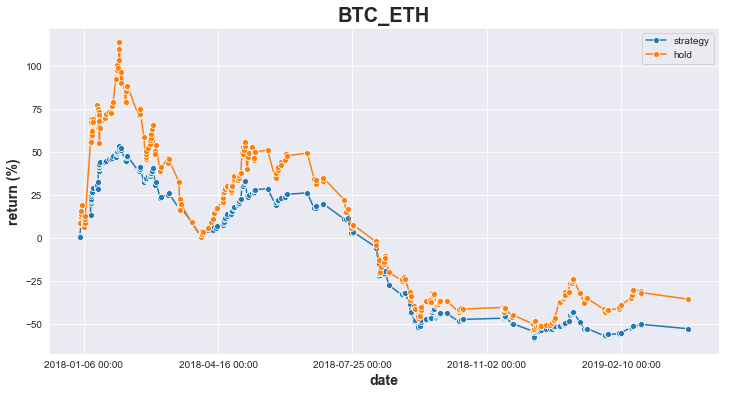

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades   339.0000
totalProfit       -2.9529
avgProfit         -0.0087
winPercentage     85.5457
avgWinTrade        1.4806
avgLossTrade      -8.8227
profitFactor       0.9932
maxDrawdown       49.7818
avgTimeToClose    56.5206
minTimeToClose     0.8000
maxTimeToClose 1,003.1000


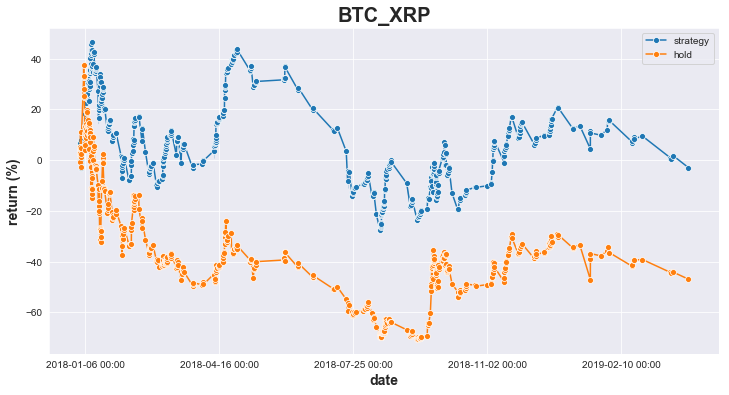

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades   216.0000
totalProfit        8.6102
avgProfit          0.0399
winPercentage     86.1111
avgWinTrade        1.1919
avgLossTrade      -7.1030
profitFactor       1.0404
maxDrawdown       56.6927
avgTimeToClose    79.1389
minTimeToClose     0.9000
maxTimeToClose 1,195.9000


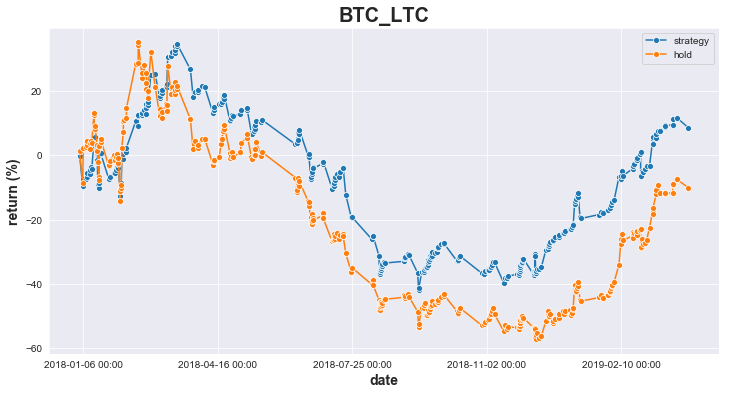

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades   311.0000
totalProfit       13.8145
avgProfit          0.0444
winPercentage     88.7460
avgWinTrade        1.1643
avgLossTrade      -8.7870
profitFactor       1.0449
maxDrawdown       38.1105
avgTimeToClose    62.8897
minTimeToClose     0.9000
maxTimeToClose 2,225.9000


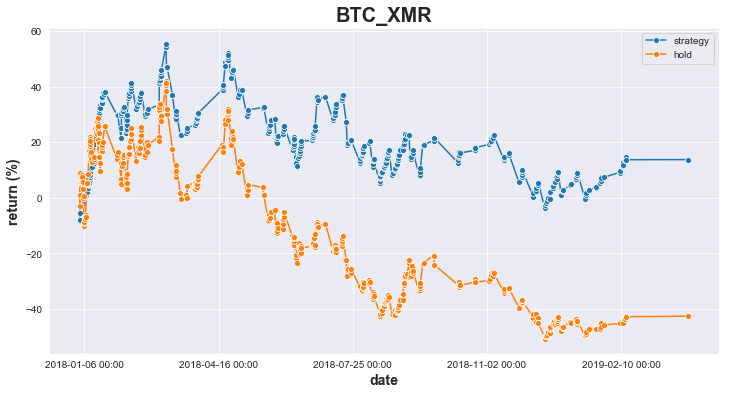

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 571.0000
totalProfit     29.1721
avgProfit        0.0511
winPercentage   85.8144
avgWinTrade      1.2398
avgLossTrade    -7.1398
profitFactor     1.0504
maxDrawdown     33.6197
avgTimeToClose  30.8021
minTimeToClose   0.1000
maxTimeToClose 608.9000


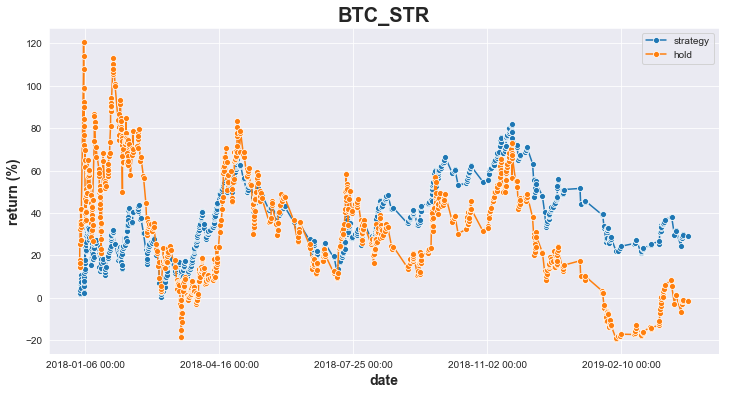

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 256.0000
totalProfit    -23.4225
avgProfit       -0.0915
winPercentage   87.8906
avgWinTrade      0.9707
avgLossTrade    -7.8009
profitFactor     0.9031
maxDrawdown     47.2651
avgTimeToClose  63.9566
minTimeToClose   0.8000
maxTimeToClose 855.7000


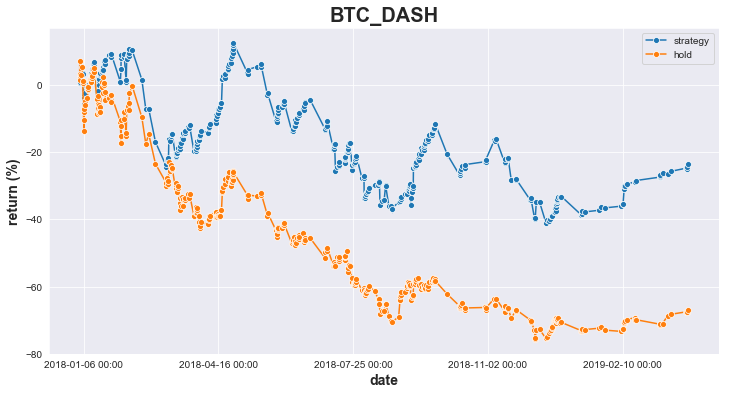

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades   403.0000
totalProfit      146.5373
avgProfit          0.3636
winPercentage     91.5633
avgWinTrade        1.2060
avgLossTrade      -8.7789
profitFactor       1.4909
maxDrawdown       29.7436
avgTimeToClose    32.2476
minTimeToClose     0.8000
maxTimeToClose 1,044.1000


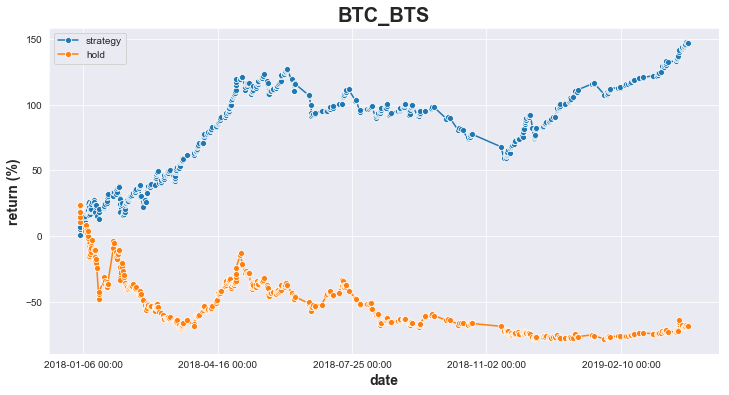

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 736.0000
totalProfit    193.0180
avgProfit        0.2623
winPercentage   89.1304
avgWinTrade      1.3945
avgLossTrade    -9.0220
profitFactor     1.2674
maxDrawdown     43.3251
avgTimeToClose  21.8931
minTimeToClose   0.7000
maxTimeToClose 587.1000


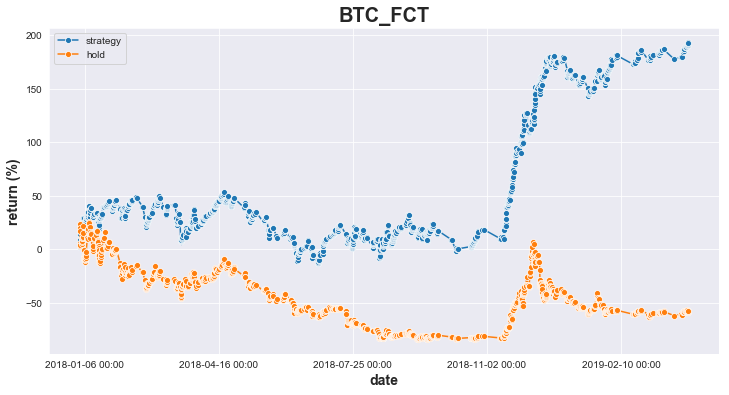

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 543.0000
totalProfit    -65.7916
avgProfit       -0.1212
winPercentage   85.4512
avgWinTrade      0.8698
avgLossTrade    -5.9414
profitFactor     0.8598
maxDrawdown     80.2089
avgTimeToClose  36.1595
minTimeToClose   0.1000
maxTimeToClose 515.9000


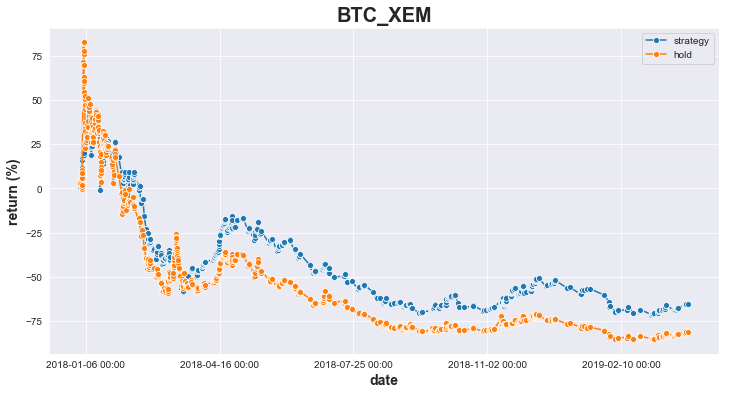

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades   416.0000
totalProfit      119.2615
avgProfit          0.2867
winPercentage     90.1442
avgWinTrade        1.0977
avgLossTrade      -7.1312
profitFactor       1.4079
maxDrawdown       20.3580
avgTimeToClose    29.6490
minTimeToClose     0.8000
maxTimeToClose 1,223.9000


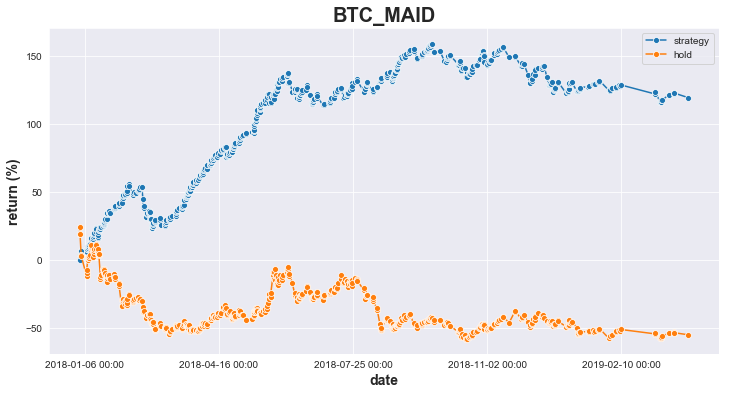

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 306.0000
totalProfit     59.8109
avgProfit        0.1955
winPercentage   90.8497
avgWinTrade      1.0976
avgLossTrade    -8.7610
profitFactor     1.2438
maxDrawdown     21.1422
avgTimeToClose  43.4797
minTimeToClose   0.8000
maxTimeToClose 833.0000


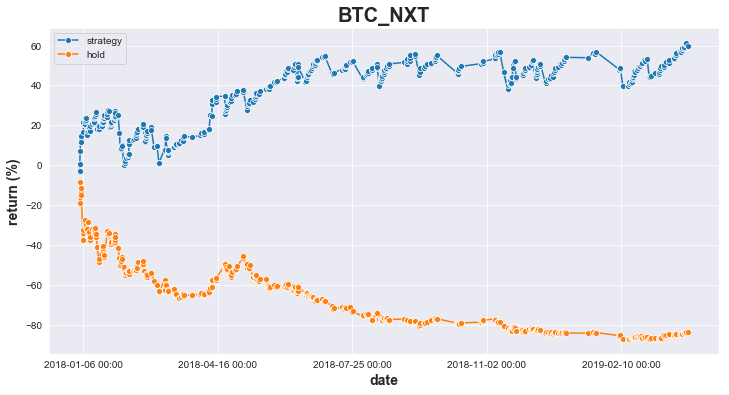

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 577.0000
totalProfit    184.3855
avgProfit        0.3196
winPercentage   89.0815
avgWinTrade      1.4645
avgLossTrade    -9.0220
profitFactor     1.3244
maxDrawdown     34.3899
avgTimeToClose  29.9069
minTimeToClose   0.8000
maxTimeToClose 589.9000


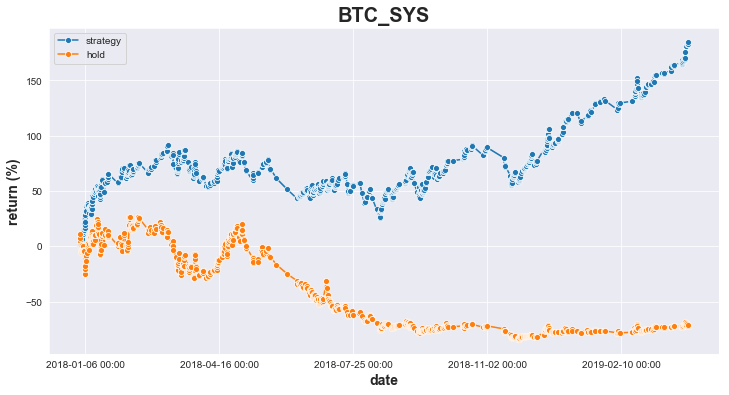

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 729.0000
totalProfit    124.9136
avgProfit        0.1713
winPercentage   89.0261
avgWinTrade      1.1641
avgLossTrade    -7.8821
profitFactor     1.1981
maxDrawdown     75.6216
avgTimeToClose  20.9977
minTimeToClose   0.1000
maxTimeToClose 350.0000


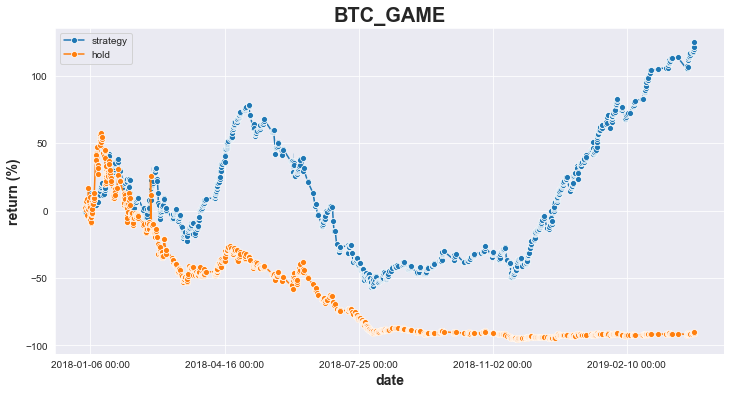

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 381.0000
totalProfit    139.1622
avgProfit        0.3653
winPercentage   91.6010
avgWinTrade      1.2260
avgLossTrade    -9.0220
profitFactor     1.4820
maxDrawdown     35.3035
avgTimeToClose  30.9105
minTimeToClose   0.7000
maxTimeToClose 431.9000


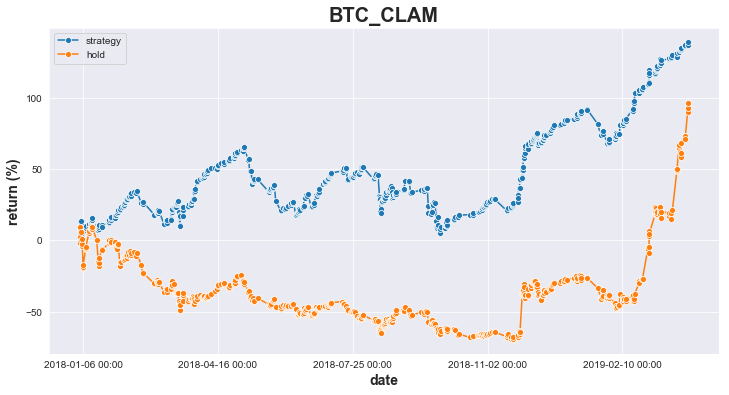

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 732.0000
totalProfit    251.3621
avgProfit        0.3434
winPercentage   90.3005
avgWinTrade      1.3395
avgLossTrade    -8.9301
profitFactor     1.3964
maxDrawdown     25.3797
avgTimeToClose  25.4620
minTimeToClose   0.1000
maxTimeToClose 706.9000


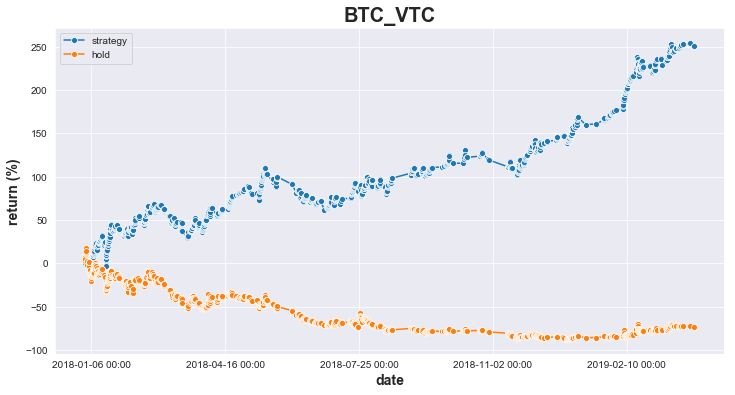

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 692.0000
totalProfit    208.2207
avgProfit        0.3009
winPercentage   85.9827
avgWinTrade      1.5166
avgLossTrade    -7.1565
profitFactor     1.3000
maxDrawdown     25.8429
avgTimeToClose  24.0020
minTimeToClose   0.1000
maxTimeToClose 399.7000


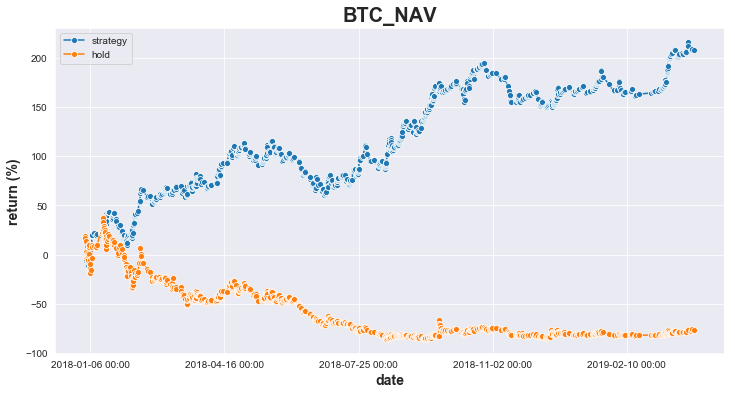

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 378.0000
totalProfit     64.2733
avgProfit        0.1700
winPercentage   87.5661
avgWinTrade      1.4752
avgLossTrade    -9.0220
profitFactor     1.1516
maxDrawdown     36.3259
avgTimeToClose  30.2370
minTimeToClose   0.2000
maxTimeToClose 438.9000


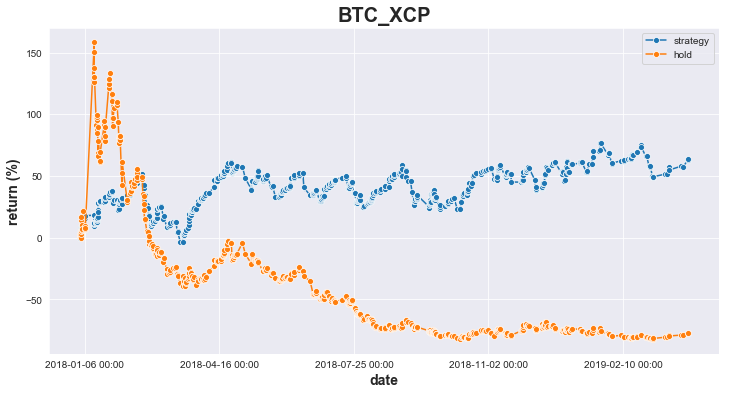

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 604.0000
totalProfit    305.0659
avgProfit        0.5051
winPercentage   90.7285
avgWinTrade      1.4786
avgLossTrade    -9.0220
profitFactor     1.6038
maxDrawdown     20.6306
avgTimeToClose  27.5219
minTimeToClose   0.2000
maxTimeToClose 431.7000


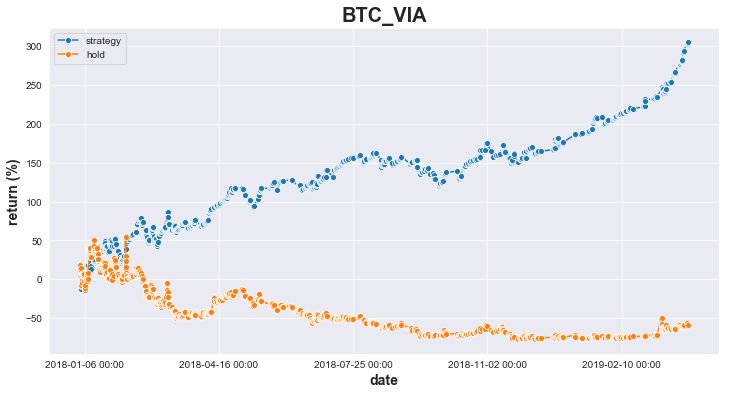

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 670.0000
totalProfit    111.9758
avgProfit        0.1671
winPercentage   89.7015
avgWinTrade      1.1805
avgLossTrade    -8.6594
profitFactor     1.1874
maxDrawdown     54.4058
avgTimeToClose  22.7490
minTimeToClose   0.2000
maxTimeToClose 814.0000


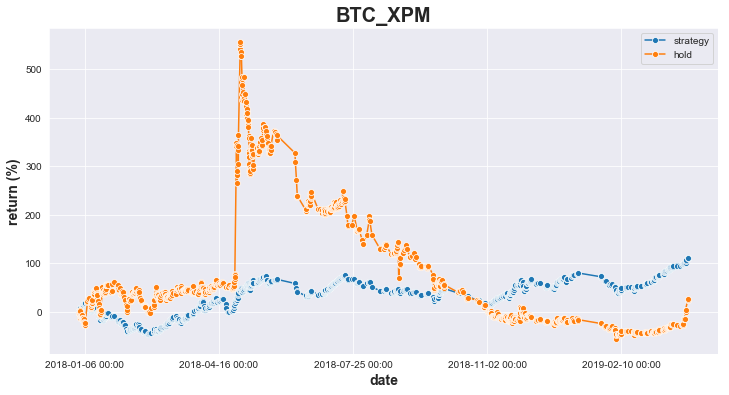

-----------------------------------------


In [138]:
for i in range(len(selected_params)):
    row = selected_params.iloc[i, :]
    pair = row['pair']
    window_size = row['window_size']
    profit_targets = row['profit_targets']
    willing_loss = row['stop_loss']
    _return = row['_return']

    data = test_dict[pair]
    data['support'] = ohlc_supports_test_dict[pair][window_size]

    strategy = get_strategy(data, pair, profit_targets, willing_loss, _return)
    print(strategy.stats('btc').report())
    df = portfolio_value(strategy, test_dict, pair)
    plot_portfolio_value(df, 1, pair)
    print('-----------------------------------------')